In [30]:
import os, importlib, sys, time

In [31]:
import numpy as np
import pandas as pd

In [32]:
import matplotlib.pyplot as plt
plt.rc('font', size=10)

In [33]:
import scipy.linalg as la
import scipy.stats as stats
import scipy.optimize as opt

In [34]:
import freqepid

# 1. parameters

In [35]:
GPi = np.load('data/GPi.npz')

In [36]:
param = pd.read_feather('data/param_ebcr_0.feather')
thetas = param.iloc[:,-3:].to_numpy()

In [37]:
regions = param.region.to_numpy()
d = thetas.shape[-1]-1

(array([ 1.,  0.,  6., 12., 18., 32., 19.,  8.,  2.,  2.]),
 array([-3.76190094, -3.42745122, -3.09300149, -2.75855177, -2.42410205,
        -2.08965233, -1.7552026 , -1.42075288, -1.08630316, -0.75185344,
        -0.41740371]),
 <BarContainer object of 10 artists>)

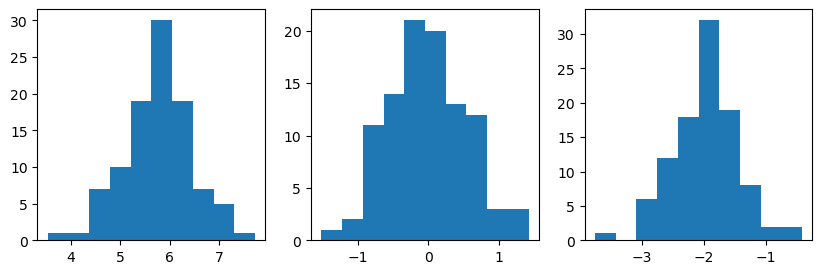

In [38]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.hist(thetas[:,0])
plt.subplot(1,3,2); plt.hist(thetas[:,1])
plt.subplot(1,3,3); plt.hist(thetas[:,2])

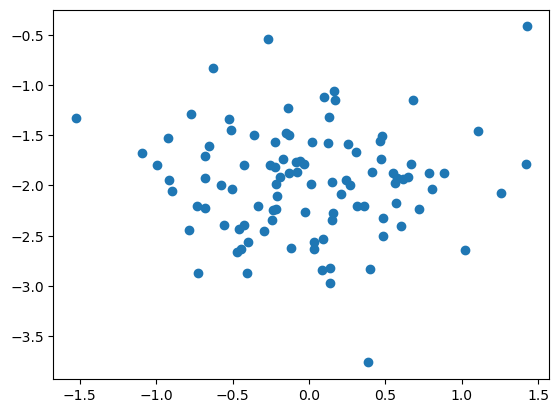

In [39]:
plt.scatter(thetas[:,1], thetas[:,2])

# 2. simulation

## load simulation

In [40]:
data = pd.read_feather('data/simulation_ebcr_0.feather')

In [41]:
data

,region,date,R,EI,infection,EY,death,intervention
0,aa,0,2.051356,268.942888,268.942888,1.253463,2,0
1,aa,1,2.051356,274.125233,274.125233,1.261948,1,0
2,aa,2,2.051356,293.149608,293.149608,1.269390,1,0
3,aa,3,2.051356,323.389441,323.389441,1.276013,1,0
4,aa,4,2.051356,361.493441,361.493441,1.282592,1,0
...,...,...,...,...,...,...,...,...
5926,dv,57,0.793476,12406.975638,12406.975638,258.117966,202,1
5927,dv,58,0.793476,12018.384962,12018.384962,251.482833,249,1
5928,dv,59,0.793476,11641.965078,11641.965078,244.854087,134,1
5929,dv,60,0.793476,11277.334793,11277.334793,238.205892,233,1


# 3. Fit results

In [42]:
model = freqepid.Model(GPi['g'], GPi['pi'], T0=40, family='nbinom')

In [43]:
result = pd.read_feather('result_epidemia_ebcr_0.feather')

In [44]:
ths_smp = np.stack([
    np.stack([
        np.log(result['seeds[%s]'%r]),
        result['R|(Intercept)'] 
           + result['R|b[(Intercept) region:%s]'%r],
        result['R|intervention'] 
           + result['R|b[intervention region:%s]'%r]
    ], 0)
    for r in regions
], 0)

In [45]:
ths_epi = np.mean(ths_smp, -1)

In [46]:
covs_epi = np.stack([
    np.cov(th_smp) for th_smp in ths_smp
])

## plot

In [47]:
chi_pa = freqepid.CV(d).chi_pa(0.05)

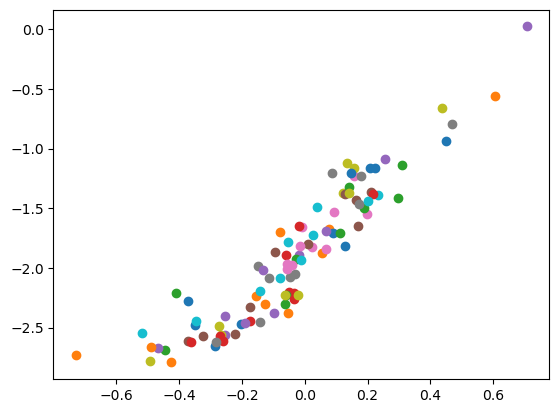

In [48]:
for i_region, (theta, th_epi, cov_epi) in enumerate(zip(thetas, ths_epi, covs_epi)):
    p = plt.scatter(*(th_epi[1:]))
#     plt.arrow(*theta[1:], *(th_epi[1:]-theta[1:]), width=0.005, 
#               length_includes_head=True,
#               color=p.get_facecolor(), alpha=1)
#     freqepid.confidence_ellipse(
#         th_epi[1:], cov_epi[1:,1:], n_std = chi_pa,
#         facecolor=p.get_facecolor(), alpha=0.3)

(-4.0, 0.0)

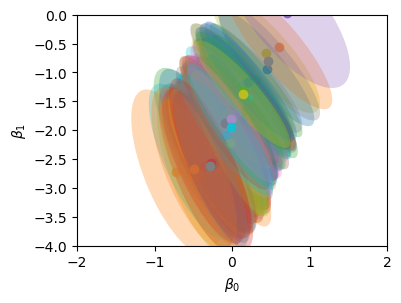

In [57]:
plt.figure(figsize=(4,3))
for i_region, (theta, th_epi, cov_epi) in enumerate(zip(thetas, ths_epi, covs_epi)):
    p = plt.scatter(*(th_epi[1:]))
#     plt.arrow(*theta[1:], *(th_epi[1:]-theta[1:]), width=0.005, 
#               length_includes_head=True,
#               color=p.get_facecolor(), alpha=1)
    freqepid.confidence_ellipse(
        th_epi[1:], cov_epi[1:,1:], n_std = chi_pa,
        facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$")
plt.xlim([-2, 2]); plt.ylim([-4, 0])

In [50]:
X2_epi = ((ths_epi[:,1:] - thetas[:,1:])[:,None,:] @ np.linalg.pinv(covs_epi[:,1:,1:]) @ (ths_epi[:,1:] - thetas[:,1:])[:,:,None])[:,0,0]

In [51]:
np.mean(X2_epi < chi_pa**2)

0.91

In [52]:
X2_epi = ((ths_epi[:,2:] - thetas[:,2:])[:,None,:] @ np.linalg.pinv(covs_epi[:,2:,2:]) @ (ths_epi[:,2:] - thetas[:,2:])[:,:,None])[:,0,0]

In [53]:
np.mean(X2_epi < freqepid.CV(1).chi_pa(0.05)**2)

0.91

In [25]:
data

,region,date,R,EI,infection,EY,death,intervention
0,aa,0,2.793710,663.159341,663.159341,2.269493,5,0
1,aa,1,2.793710,684.959935,684.959935,2.284859,2,0
2,aa,2,2.793710,765.289339,765.289339,2.298409,1,0
3,aa,3,2.793710,894.686197,894.686197,2.310808,0,0
4,aa,4,2.793710,1062.488410,1062.488410,2.324146,1,0
...,...,...,...,...,...,...,...,...
5926,dv,57,0.781587,7395.889851,7395.889851,161.678134,268,1
5927,dv,58,0.781587,7149.987153,7149.987153,157.247945,70,1
5928,dv,59,0.781587,6912.260366,6912.260366,152.833536,116,1
5929,dv,60,0.781587,6682.437653,6682.437653,148.417982,206,1


In [26]:
param.region[3]

'ad'

In [27]:
Y = np.array(data[data.region == param.region[3]].death)
T = Y.shape[0]

A = np.zeros([T, d])
A[:,0] = np.full(T, 1)
A[:,1:] = np.array(data[data.region == param.region[3]].intervention)[:,None]

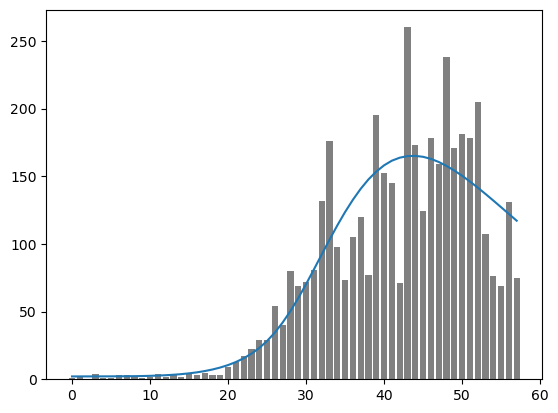

In [28]:
plt.bar(np.arange(T), Y, color='grey')
plt.plot(model.predict_EY(A, ths_epi[3,0], ths_epi[3,1:]))

In [117]:
ths_epi[3]

array([ 5.66592696, -0.18306259, -1.6985919 ])

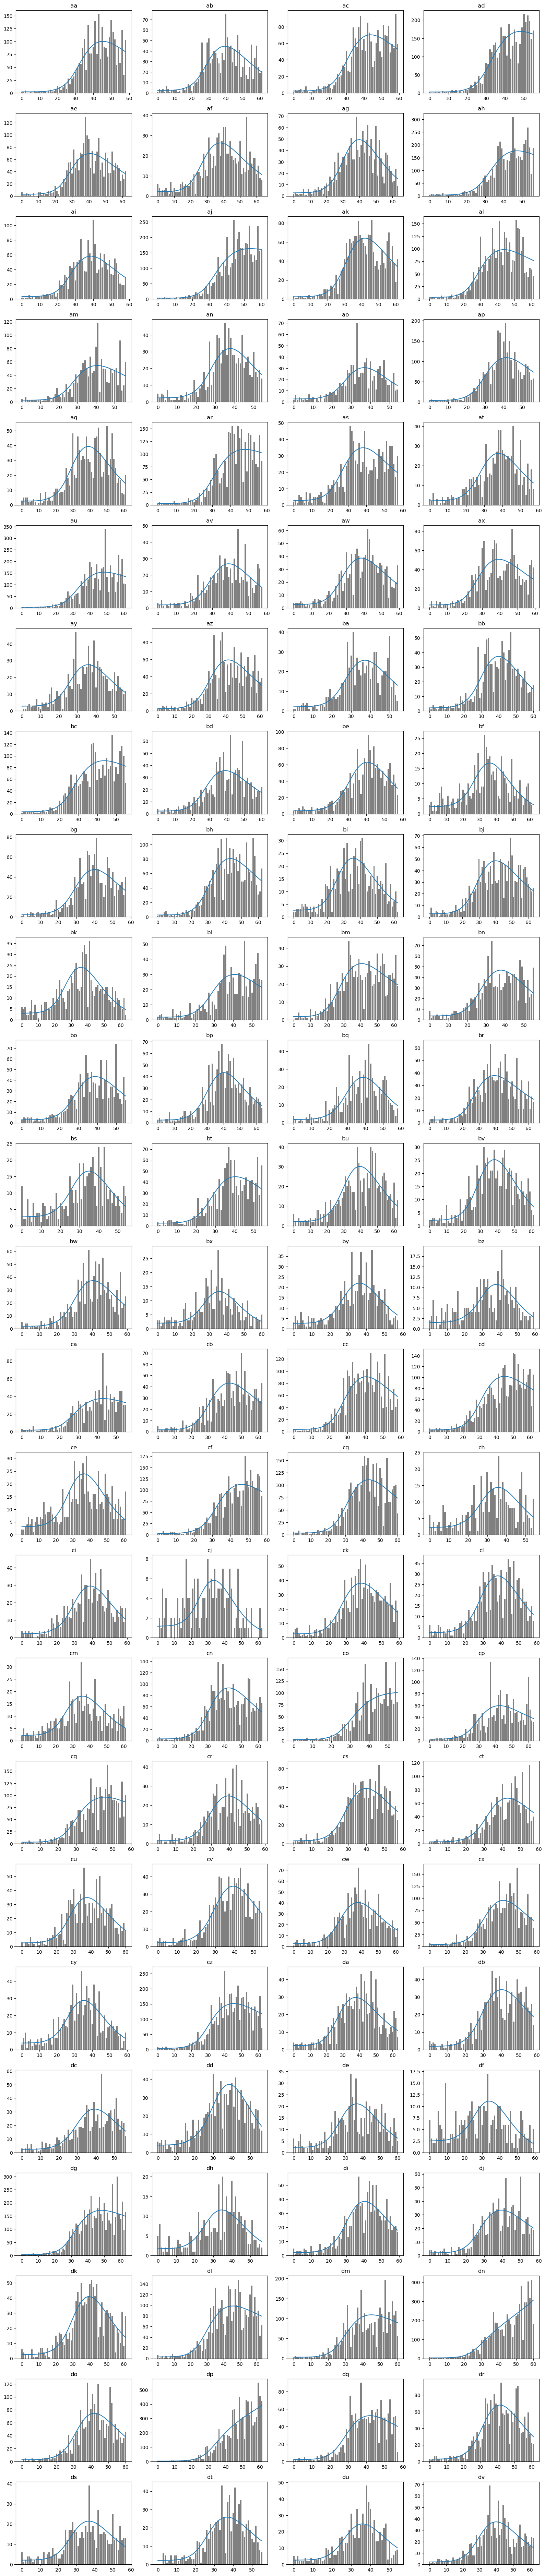

In [119]:
plt.figure(figsize=(16, int(num_region/4+1)*3))

for i, r in enumerate(regions):
    plt.subplot(int(num_region/4+1),4,i+1)
    
    Y = np.array(data[data.region == r].death)
    T = Y.shape[0]
    
    A = np.zeros([T, d])
    A[:,0] = np.full(T, 1)
    A[:,1:] = np.array(data[data.region == r].intervention)[:,None]

    plt.bar(np.arange(T), Y, color='grey')
    plt.plot(model.predict_EY(A, ths_epi[i,0], ths_epi[i,1:]))
    plt.title('%s'%r)
    
plt.tight_layout()